Plan for ML models
1. Prepare Data
2. Build Baseline models
   * set baseline scores of best models on test dataset
3. Hyperparameter Tunning
   * Rnadomized Search
   * Grid Search
4. Ensemble Techinques

List of models:
1. Random Forest
2. XGBoost
3. LightGBM
4. Lasso
5. Ridge
6. ElasticNet
7. SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg 
from sklearn.base import BaseEstimator, RegressorMixin
import joblib

In [2]:
# 1. As a remainder, in feature engineering section I have found out tha our ML model work better on the dataset with new features
dataset_df = pd.read_csv(r"C:\Users\Adam\Desktop\main\programming\machine learning\house prices regression\data\preprocessed\dataset_with_new_features_rep.csv")
dataset_df.head()

Unnamed: 0  Id  MSSubClass MSZoning  LotFrontage   LotArea Street LotShape  \
0           0   1    4.110874       RL     4.189655  9.042040   Pave      Reg   
1           1   2    3.044522       RL     4.394449  9.169623   Pave      Reg   
2           2   3    4.110874       RL     4.234107  9.328212   Pave      IR1   
3           3   4    4.262680       RL     4.110874  9.164401   Pave      IR1   
4           4   5    4.110874       RL     4.442651  9.565284   Pave      IR1   

  LandContour Utilities  ... YrSold SaleType SaleCondition AgeOfHouse  \
0         Lvl    AllPub  ...   2008       WD        Normal          5   
1         Lvl    AllPub  ...   2007       WD        Normal         31   
2         Lvl    AllPub  ...   2008       WD        Normal          7   
3         Lvl    AllPub  ...   2006       WD       Abnorml         91   
4         Lvl    AllPub  ...   2008       WD        Normal          8   

  YearsSinceRenov TotalBathNum PorchSize  IsBasement  IsFirePlace  IsGarage  
0               5     4.000000  4.127134        True        False      True  
1              31     2.693147  0.000000        True         True      True  
2               6     4.000000  3.761200        True         True      True  
3              36     2.000000  9.192991        True         True      True  
4               8     4.000000  4.442651        True         True      True  

[5 rows x 84 columns]

In [3]:
# In order to train and evaluate our ML models we need to preprocess our model. For this purpose I will use previously created pipeline
def my_pipeline(df):
    """
    Encodes non-numeric columns using OneHotEncoder and scales numeric columns using StandardScaler.

    Parameters:
        df (pd.DataFrame): Input dataset as a pandas DataFrame.

    Returns:
        pd.DataFrame: Transformed dataset with encoded and scaled features.
    """
    # Identify numeric and categorical columns
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Define transformers for numeric and categorical features
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    # Combine transformers in a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Apply transformations
    transformed_data = preprocessor.fit_transform(df)

    # Get column names for transformed data
    cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_columns = numeric_features + list(cat_columns)

    # Create a DataFrame with transformed data
    transformed_df = pd.DataFrame(transformed_data, columns=all_columns, index=df.index)

    return transformed_df

In [26]:
dataset_proc = my_pipeline(dataset_df)
#dataset_proc.head()
train_raw = pd.read_csv(r"C:\Users\Adam\Desktop\main\programming\machine learning\house prices regression\data\raw\train.csv")
test_raw = pd.read_csv(r"C:\Users\Adam\Desktop\main\programming\machine learning\house prices regression\data\raw\test.csv")
train_len = len(train_raw)
train_proc = dataset_proc[:train_len]
test_proc = dataset_proc[train_len:]
print(f'Shape of the preprocessed combined dataset: {dataset_proc.shape}')
print(f'Shape of the preprocessed train dataset: {train_proc.shape}')
print(f'Shape of the preprocessed test dataset: {test_proc.shape}')

Shape of the preprocessed combined dataset: (2919, 297)
Shape of the preprocessed train dataset: (1460, 297)
Shape of the preprocessed test dataset: (1459, 297)


In [5]:
# split into train and valid data
X = train_proc
y = train_raw['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2,
                                                  random_state=42)

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
def evaluate_models(models, X_train, X_val, y_train, y_val):
    """
    Evaluate multiple models and return a DataFrame with their names and scores.
    Parameters:
     -models: (dictionary) Dictionary of models with keys as model names and values as model instances.
     -X_train, X_val, y_train, y_test: training and evaluating arrays
    """
    results = []
    for model_name, model in models.items():
        print(f'Training model: {model_name}')
        model.fit(X_train, y_train)
        y_preds = model.predict(X_val)
        val_rmse = rmse(y_val, y_preds)
        results.append({"Model": model_name, "RMSE": val_rmse})
    results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)
    return results_df

In [36]:
# 2.Build baseline models
models = {'RandomForestRegressor': RandomForestRegressor(random_state=42),
          'XGBoostRegressor': XGBRegressor(random_state=42),
          'Lasso': Lasso(random_state=42),
          'Ridge':Ridge(random_state=42),
          'LinearRegression': LinearRegression(),
          'ElasticNet':ElasticNet(random_state=42),
          'SVR':SVR()}

In [37]:
results_df = evaluate_models(models, X_train, X_val, y_train, y_val)
results_df

Training model: RandomForestRegressor
Training model: XGBoostRegressor
Training model: Lasso


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.740e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Training model: Ridge
Training model: LinearRegression
Training model: ElasticNet
Training model: SVR


Model          RMSE
1       XGBoostRegressor  26264.884542
0  RandomForestRegressor  28853.150088
2                  Lasso  31003.796030
3                  Ridge  31286.211130
4       LinearRegression  31510.703022
5             ElasticNet  39269.825527
6                    SVR  88623.241394

In [23]:
y_true = train_raw['SalePrice']

In [30]:
# Let's set a threshold. For this I will use 3 best models on this list

models = {'XGBoostRegressor': XGBRegressor(random_state=42),
          'RandomForestRegressor': RandomForestRegressor(random_state=42),
          'Lasso': Lasso(random_state=42)}


preds = [] 
for name, model in models.items(): 
    model = model.fit(train_proc, y_true)
    y_preds = model.predict(test_proc)
    preds_df = pd.DataFrame({'Id': test_raw['Id'], 'SalePrice': y_preds.flatten()})
    preds.append(preds_df)
    name_csv = 'submission_ml_base_' + name + '.csv'
    preds_df.to_csv(name_csv,index=False)

C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.321e+10, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


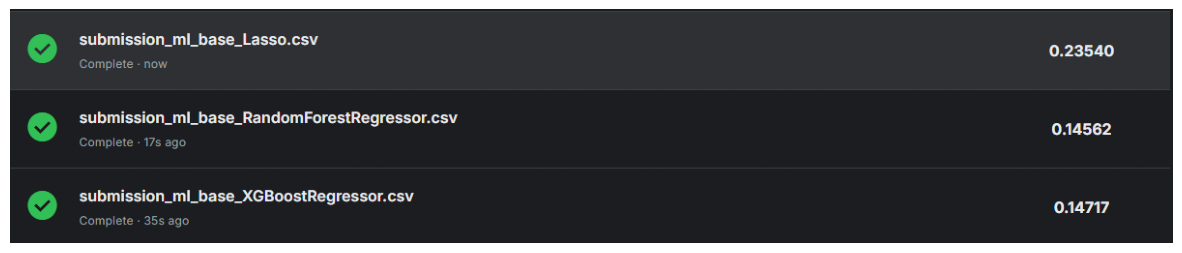

In [35]:
img = mpimg.imread(r"C:\Users\Adam\Desktop\main\programming\machine learning\house prices regression\reports\threhshold_ml.png")

plt.figure(figsize=(15,12))
plt.imshow(img)
plt.axis('off')
plt.show()

### NOTE
Right so on the ss above we can see already an advantage that this models have. As a remainder DNNs threshold did score about 0.16.

In [45]:
# 2.Hyperparameter tunning. XGBoostRegressor
learning_rate_vals = [0.001, 0.01, 0.5, 0.1, 0.3]

results = []
for value in learning_rate_vals:
    print(f'Training model with learning_rate={value}')
    model = XGBRegressor(learning_rate=value,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'learning_rate':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df

Training model with learning_rate=0.001
Training model with learning_rate=0.01
Training model with learning_rate=0.5
Training model with learning_rate=0.1
Training model with learning_rate=0.3


learning_rate  validation rmse
0          0.001     80932.643599
1          0.010     45783.128421
2          0.500     28753.341093
3          0.100     24627.191476
4          0.300     26264.884542

In [62]:
learning_rate_vals = [round(x,2 ) for x in np.arange(0.05,0.25, 0.01).tolist()]

results = []
for value in learning_rate_vals:
    #print(f'Training model with learning_rate={value}')
    model = XGBRegressor(learning_rate=value,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'learning_rate':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse').head(5)

learning_rate  validation rmse
4            0.09     24441.407488
18           0.23     24521.460315
5            0.10     24627.191476
13           0.18     24899.083357
2            0.07     25037.359605

In [71]:
# learnirng rate value 0.09 tend to work the best. Let's move on to the n_estimators
n_estimator_vals = [i for i in range(100,1100, 100)]
results = []
for value in n_estimator_vals:
    print(f'Training XGB with n_estimators={value}')
    model = XGBRegressor(learning_rate=0.09, random_state=42, n_estimators=value)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'n_estimators':value, 'val_rmse':val_rmse})

results_df = pd.DataFrame(results)
results_df.sort_values(by='val_rmse').head(5)

Training XGB with n_estimators=100
Training XGB with n_estimators=200
Training XGB with n_estimators=300
Training XGB with n_estimators=400
Training XGB with n_estimators=500
Training XGB with n_estimators=600
Training XGB with n_estimators=700
Training XGB with n_estimators=800
Training XGB with n_estimators=900
Training XGB with n_estimators=1000


n_estimators      val_rmse
1           200  24275.707034
9          1000  24329.323213
8           900  24329.904562
5           600  24330.710799
6           700  24330.751571

In [72]:
n_estimator_vals = [150,200,250, 950,1000,1050]
results = []
for value in n_estimator_vals:
    print(f'Training XGB with n_estimators={value}')
    model = XGBRegressor(learning_rate=0.09, random_state=42, n_estimators=value)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'n_estimators':value, 'val_rmse':val_rmse})

results_df = pd.DataFrame(results)
results_df.sort_values(by='val_rmse').head(5)

Training XGB with n_estimators=150
Training XGB with n_estimators=200
Training XGB with n_estimators=250
Training XGB with n_estimators=950
Training XGB with n_estimators=1000
Training XGB with n_estimators=1050


n_estimators      val_rmse
1           200  24275.707034
0           150  24309.345034
2           250  24326.918753
5          1050  24328.918102
4          1000  24329.323213

In [78]:
# 200 has won the competition
max_depth_vals = [None, 3, 5, 10]
results = []
for value in max_depth_vals:
    print(f'Training model with max_depth: {value}')
    model = XGBRegressor(learning_rate=0.09, n_estimators=200, max_depth=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'n_estimators':value, 'rmse':val_rmse})
results_df = pd.DataFrame(results).sort_values(by='rmse')
results_df

Training model with max_depth: None
Training model with max_depth: 3
Training model with max_depth: 5
Training model with max_depth: 10


n_estimators          rmse
0           NaN  24275.707034
2           5.0  24320.299998
1           3.0  25481.793343
3          10.0  28321.271158

In [80]:
# 200 has won the competition
max_depth_vals = [None, 1, 4, 6, 11, 12]
results = []
for value in max_depth_vals:
    print(f'Training model with max_depth: {value}')
    model = XGBRegressor(learning_rate=0.09, n_estimators=200, max_depth=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'n_estimators':value, 'rmse':val_rmse})
results_df = pd.DataFrame(results).sort_values(by='rmse')
results_df

Training model with max_depth: None
Training model with max_depth: 1
Training model with max_depth: 4
Training model with max_depth: 6
Training model with max_depth: 11
Training model with max_depth: 12


n_estimators          rmse
0           NaN  24275.707034
3           6.0  24275.707034
2           4.0  25412.178498
4          11.0  28063.692131
5          12.0  28636.385247
1           1.0  31726.113913

In [84]:
# Let's make predictions nad see how much further we got
model = XGBRegressor(learning_rate=0.09, n_estimators=200, max_depth=None, random_state=42)
model.fit(train_proc, y_true)
y_preds = model.predict(test_proc)
submission_xg_df = pd.DataFrame({'Id':test_raw['Id'], 'SalePrice': y_preds})
submission_xg_df

Id      SalePrice
0     1461  120976.335938
1     1462  161740.828125
2     1463  186844.984375
3     1464  197040.015625
4     1465  195623.203125
...    ...            ...
1454  2915   79241.382812
1455  2916   77405.296875
1456  2917  164899.046875
1457  2918  120233.054688
1458  2919  221443.812500

[1459 rows x 2 columns]

In [85]:
submission_xg_df.to_csv('submission_xgb_tunned.csv',index=False)

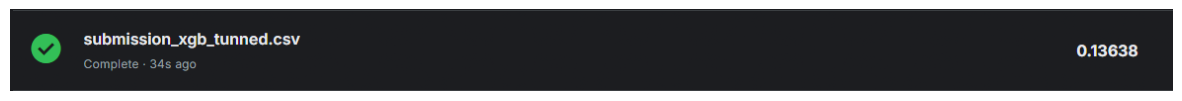

In [87]:
img = mpimg.imread(r"C:\Users\Adam\Desktop\main\programming\machine learning\house prices regression\reports\xgb_tunned.png")
plt.figure(figsize=(15,12))
plt.imshow(img)
plt.axis('off')
plt.show()

### NOTE 
With this score we have almost did better than best version of dnns. Let's move further. Next model to tunne is Random Forest Regressor. 

In [89]:
# 2.Hyperparameter tunning. RandomForestRegressor
n_estimators = [100,200,300,400,500,800,1000]

results = []
for value in n_estimators:
    print(f'Training model with n_estimators={value}')
    model = RandomForestRegressor(n_estimators=value ,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'learning_rate':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df

Training model with n_estimators=100
Training model with n_estimators=200
Training model with n_estimators=300
Training model with n_estimators=400
Training model with n_estimators=500
Training model with n_estimators=800
Training model with n_estimators=1000


learning_rate  validation rmse
0            100     28853.150088
1            200     28806.578856
2            300     28819.863304
3            400     28663.712617
4            500     28726.831723
5            800     28737.520243
6           1000     28745.502941

In [90]:
n_estimators = [50,100,150,180]

results = []
for value in n_estimators:
    print(f'Training model with n_estimators={value}')
    model = RandomForestRegressor(n_estimators=value ,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'learning_rate':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df

Training model with n_estimators=50
Training model with n_estimators=100
Training model with n_estimators=150
Training model with n_estimators=180


learning_rate  validation rmse
0             50     29614.597587
1            100     28853.150088
2            150     28553.533021
3            180     28644.605843

In [99]:
# n_estimators=100
max_depth_vals = [10,20,30,40,50]

results = []
for value in max_depth_vals:
    print(f'Training model with n_estimators={value}')
    model = RandomForestRegressor(n_estimators=100, max_depth=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'max_depth_vals':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results).sort_values(by='validation rmse')
results_df

Training model with n_estimators=10
Training model with n_estimators=20
Training model with n_estimators=30
Training model with n_estimators=40
Training model with n_estimators=50


max_depth_vals  validation rmse
3              40     28853.150088
2              30     28853.150088
4              50     28853.150088
0              10     29015.902892
1              20     29142.389599

In [97]:
model = RandomForestRegressor(n_estimators=100, max_depth=value, random_state=42)
model.fit(X_train, y_train)
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [101]:
# n_estimators=100
min_samples = [2,4,5,8,10]

results = []
for value in min_samples:
    print(f'Training model with n_estimators={value}')
    model = RandomForestRegressor(n_estimators=100, max_depth=40, min_samples_split=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'max_depth_vals':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df

Training model with n_estimators=2
Training model with n_estimators=4
Training model with n_estimators=5
Training model with n_estimators=8
Training model with n_estimators=10


max_depth_vals  validation rmse
0               2     28853.150088
1               4     28995.736815
2               5     28985.819852
3               8     29038.409909
4              10     29318.572282

In [105]:
# n_estimators=100
min_samples_leaf_vals = [1,2,3,4,5]

results = []
for value in min_samples_leaf_vals:
    print(f'Training model with min_samples_leaf={value}')
    model = RandomForestRegressor(n_estimators=100, max_depth=40, min_samples_split=2, min_samples_leaf=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'min_samples_leaf':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df

Training model with min_samples_leaf=1
Training model with min_samples_leaf=2
Training model with min_samples_leaf=3
Training model with min_samples_leaf=4
Training model with min_samples_leaf=5


min_samples_leaf  validation rmse
0                 1     28853.150088
1                 2     29190.363677
2                 3     29435.766357
3                 4     30504.075953
4                 5     31310.636345

In [108]:
# Lassso 
alpha_vals = [0.001,0.01,0.1,1]
results = []
for value in alpha_vals:
    print(f'Training model with alpha={value}')
    model = Lasso(alpha=value,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'alpha':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse')

Training model with alpha=0.001


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Training model with alpha=0.01
Training model with alpha=0.1
Training model with alpha=1


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.551e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.740e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


alpha  validation rmse
3  1.000     31003.796030
2  0.100     31059.594797
1  0.010     31065.814424
0  0.001     31068.218479

In [111]:
# Lassso 
alpha_vals = [0.8,1,1.2,1.4,1.6]
results = []
for value in alpha_vals:
    print(f'Training model with alpha={value}')
    model = Lasso(alpha=value,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'alpha':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse')

Training model with alpha=0.8
Training model with alpha=1


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.934e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.740e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Training model with alpha=1.2
Training model with alpha=1.4


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.734e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.006e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Training model with alpha=1.6


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.034e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


alpha  validation rmse
4    1.6     30966.421620
3    1.4     30977.994764
2    1.2     30990.736409
1    1.0     31003.796030
0    0.8     31016.667778

In [117]:
# Lassso 
alpha_vals = [1.6,2,3,5,10,100]
results = []
for value in alpha_vals:
    print(f'Training model with alpha={value}')
    model = Lasso(alpha=value,random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'alpha':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse')

Training model with alpha=1.6


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.034e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.090e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Training model with alpha=2
Training model with alpha=3


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.372e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Training model with alpha=5
Training model with alpha=10
Training model with alpha=100


C:\Users\Adam\anaconda3\envs\housing-prices\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


alpha  validation rmse
5  100.0     30573.908636
4   10.0     30577.294711
3    5.0     30800.664529
2    3.0     30897.631482
1    2.0     30945.135955
0    1.6     30966.421620

In [119]:
# Lassso 
max_iter_vals = [1000,2000,3000,4000,5000]
results = []
for value in max_iter_vals:
    print(f'Training model with max_iter_val={value}')
    model = Lasso(alpha=100, max_iter= value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'max_iter_val':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse')

Training model with max_iter_val=1000
Training model with max_iter_val=2000
Training model with max_iter_val=3000
Training model with max_iter_val=4000
Training model with max_iter_val=5000


max_iter_val  validation rmse
0          1000     30573.908636
1          2000     30573.908636
2          3000     30573.908636
3          4000     30573.908636
4          5000     30573.908636

In [120]:
# Simmilar situation might happend with ridge regression but it is always worth to check it
# Lassso 
alpha_vals = [0.001,0.01,0.1,1]
results = []
for value in alpha_vals:
    print(f'Training model with alpha={value}')
    model = Ridge(alpha=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'alpha':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse')

Training model with alpha=0.001
Training model with alpha=0.01
Training model with alpha=0.1
Training model with alpha=1


alpha  validation rmse
3  1.000     31286.211130
2  0.100     31290.685499
1  0.010     31474.945686
0  0.001     31506.910920

In [121]:
# Simmilar situation might happend with ridge regression but it is always worth to check it
# Lassso 
alpha_vals = [1,1.2,1.4,1.6]
results = []
for value in alpha_vals:
    print(f'Training model with alpha={value}')
    model = Ridge(alpha=value, random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    val_rmse = rmse(y_val, y_preds)
    results.append({'alpha':value, 'validation rmse':val_rmse})
results_df = pd.DataFrame(results)
results_df.sort_values(by='validation rmse')

Training model with alpha=1
Training model with alpha=1.2
Training model with alpha=1.4
Training model with alpha=1.6


alpha  validation rmse
0    1.0     31286.211130
1    1.2     31320.466862
2    1.4     31352.481586
3    1.6     31382.154360

### NOTE 
Now I think is a good time to try some ensembling. XGBRegressor is not natively integrated with scikit learn so I need to wrap it in a custom class so I can use voting_regressor later.

In [137]:
class XGBRegressorWrapper(RegressorMixin, BaseEstimator):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        return self.model.score(X, y)

# Define models
xgb = XGBRegressorWrapper(learning_rate=0.09, n_estimators=200, max_depth=None, random_state=42)
rf = RandomForestRegressor(n_estimators=100, max_depth=40, min_samples_split=2, min_samples_leaf=1, random_state=42)
lasso = Lasso(alpha=100, max_iter=1000, random_state=42)
ridge = Ridge(random_state=42)
lr = LinearRegression()

voting_regressor = VotingRegressor(estimators=[
    ('xgb', xgb),
    ('rf', rf),
    ('lasso', lasso),
    ('ridge', ridge),
    ('lr', lr)
])

voting_regressor.fit(X_train, y_train)
y_pred = voting_regressor.predict(X_val)
val_rmse = rmse(y_val, y_pred)

print(f'Validation RMSE: {val_rmse}')

Validation RMSE: 26986.247361641417


### NOTE
This just did better than any other method! Now the finall step, predictions on test data.

In [139]:
voting_regressor.fit(train_proc, y_true)
y_preds = voting_regressor.predict(test_proc)
ensembled_ml_submission = pd.DataFrame({'Id':test_raw['Id'], 'SalePrice':y_preds})
ensembled_ml_submission.to_csv('ensembled_ml_submission.csv',index=False)

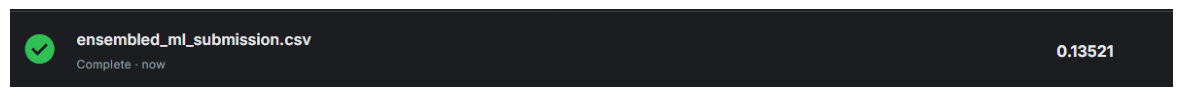

In [6]:
img = mpimg.imread(r"C:\Users\Adam\Desktop\main\programming\machine learning\house prices regression\reports\submission_ml_ensembled.png")
plt.figure(figsize=(15,12))
plt.imshow(img)
plt.axis('off')
plt.show()

### NOTE
This score almost doesn't differ from one established by DNNs.

In [4]:
xgb = XGBRegressorWrapper(learning_rate=0.09, n_estimators=200, max_depth=None, random_state=42)
rf = RandomForestRegressor(n_estimators=100, max_depth=40, min_samples_split=2, min_samples_leaf=1, random_state=42)
lasso = Lasso(alpha=100, max_iter=1000, random_state=42)
ridge = Ridge(random_state=42)
lr = LinearRegression()

joblib.dump(xgb, 'xgb_model_v1.pkl')
joblib.dump(rf, 'rf_model_v1.pkl')
joblib.dump(lasso, 'lasso_model_v1.pkl')
joblib.dump(ridge, 'ridge_model_v1.pkl')
joblib.dump(lr, 'lr_model_v1.pkl')

['lr_model_v1.pkl']